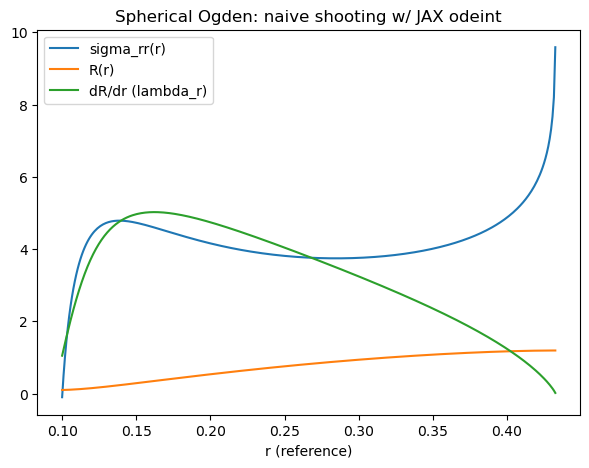

In [1]:
import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) Ogden strain-energy (single-term for demo)
# ------------------------------------------------------------
def W_ogden(lr, lt, mu, alpha):
    """
    lr = lambda_r
    lt = lambda_theta
    (Ignoring volumetric compressibility for simplicity.)
    Single-term Ogden:
      W = (2 mu / alpha^2)[ lr^alpha + 2 lt^alpha - 3 ]
    """
    return (2.0 * mu / alpha**2) * (lr**alpha + 2.0 * lt**alpha - 3.0)

# ------------------------------------------------------------
# 2) Cauchy stress formulas in spherical symmetry
# ------------------------------------------------------------
def sigma_rr_func(lr, lt, mu, alpha):
    """
    sigma_rr = (1 / (lr * lt^2)) [ lr * dW/d(lr) ]
             = (1 / lt^2) dW/d(lr)
    We'll let JAX autodiff compute dW/d(lr).
    """
    dW_dlr = jax.grad(lambda x: W_ogden(x, lt, mu, alpha))(lr)
    return (1.0 / (lr * lt**2)) * (lr * dW_dlr)

def sigma_tt_func(lr, lt, mu, alpha):
    """
    sigma_tt = (1 / (lr * lt^2)) [ lt * dW/d(lt) ]
             = (1 / (lr * lt)) dW/d(lt)
    """
    dW_dlt = jax.grad(lambda x: W_ogden(lr, x, mu, alpha))(lt)
    return (1.0 / (lr * lt**2)) * (lt * dW_dlt)

# ------------------------------------------------------------
# 3) Define the ODE system: y' = f(y, r, mu, alpha, p)
#
#    y = [sigma_rr, R, Rprime] = state vector
#    r = radial coordinate
# ------------------------------------------------------------
def spherical_ode(y, r, mu, alpha, p):
    """
    y[0] = sigma_rr_val
    y[1] = R_val       (the current radius of the material point originally at r)
    y[2] = Rprime_val  = dR/dr = lambda_r
    We want dy/dr = [dsigma_rr/dr, dR/dr, dRprime/dr].
    """
    sigma_rr_val, R_val, Rprime_val = y

    # 3.1) Local stretches
    lr = Rprime_val          # lambda_r
    lt = R_val / r           # lambda_theta

    # 3.2) Hoop stress
    sigma_tt_val = sigma_tt_func(lr, lt, mu, alpha)

    # 3.3) radial equilibrium:
    #      d(sigma_rr)/dr = -2/r (sigma_rr - sigma_tt)
    dsigma_rr_dr = - (2.0 / r) * (sigma_rr_val - sigma_tt_val)

    # 3.4) geometry: dR/dr = Rprime_val
    dR_dr = Rprime_val

    # 3.5) we want sigma_rr_val == sigma_rr_func(lr, lt, mu, alpha)
    #      If there's mismatch, we adjust Rprime_val. For demonstration,
    #      do a naive approach: mismatch * factor
    sigma_rr_calc = sigma_rr_func(lr, lt, mu, alpha)
    mismatch = sigma_rr_val - sigma_rr_calc
    dRprime_dr = -10.0 * mismatch  # "relaxation" update

    return jnp.array([dsigma_rr_dr, dR_dr, dRprime_dr])

# ------------------------------------------------------------
# 4) Shooting method driver
#
#    We'll integrate from Ri to Ro with an initial guess for:
#      sigma_rr(Ri) = -p  (boundary condition)
#      R(Ri) = Ri + e.g. 0.0
#      Rprime(Ri) = guess
# ------------------------------------------------------------
def solve_sphere_shooting(Ri, Ro, p, mu, alpha,
                          R_init_offset=0.0,
                          Rprime_init=1.0,
                          npts=1000):
    """
    Ri, Ro: inner and outer radius (reference coords)
    p: internal pressure
    mu, alpha: Ogden material params
    R_init_offset: how much we assume the inner radius moved outward
    Rprime_init: initial guess for dR/dr at r=Ri
    """
    # State at r=Ri:
    sigma_rr_init = -p        # radial stress = -p at inner boundary
    R_init        = Ri + R_init_offset
    # Rprime_init provided by user
    y0 = jnp.array([sigma_rr_init, R_init, Rprime_init])

    # radial points
    rs = jnp.linspace(Ri, Ro, num=npts)

    # Integrate
    sol = odeint(spherical_ode,    # f(y, r, mu, alpha, p)
                 y0,              # initial state
                 rs,              # "times" array
                 mu, alpha, p)    # extra parameters

    # unpack solution
    sigma_rr_sol = sol[:, 0]
    R_sol        = sol[:, 1]
    Rprime_sol   = sol[:, 2]

    return rs, sigma_rr_sol, R_sol, Rprime_sol

# ------------------------------------------------------------
# 5) Example usage
# ------------------------------------------------------------
def main():
    # Example parameters
    Ri   = .1    # inner radius
    Ro   = 2.0    # outer radius
    p    = 0.1    # internal pressure
    mu   = 10.0    # Ogden shear param
    alpha= 1.1    # Ogden exponent

    # initial guess for displacement at Ri and slope
    R_offset   = 0.0
    Rprime_init= 1.05

    rs, sigma_rr_sol, R_sol, Rprime_sol = solve_sphere_shooting(
        Ri, Ro, p, mu, alpha,
        R_init_offset=R_offset,
        Rprime_init=Rprime_init,
        npts=2000
    )

    # Plot
    plt.figure(figsize=(7,5))
    plt.plot(rs, sigma_rr_sol, label="sigma_rr(r)")
    plt.plot(rs, R_sol,        label="R(r)")
    plt.plot(rs, Rprime_sol,   label="dR/dr (lambda_r)")
    plt.xlabel("r (reference)")
    plt.legend()
    plt.title("Spherical Ogden: naive shooting w/ JAX odeint")
    plt.show()

if __name__ == "__main__":
    main()


gpu
